In [53]:
import pandas
import matplotlib.pyplot as plt
import matplotlib
import pickle
import wntr
import numpy as np
import pandas as pd

import os
import sys
sys.path.append('../Code/')

from testWN import testWN as twm

from sklearn.cluster import AgglomerativeClustering, FeatureAgglomeration, SpectralClustering
from sklearn.decomposition import PCA

In [5]:
%matplotlib notebook

# Get Network Information

In [2]:
inp_file = '../Code/c-town_true_network_simplified_controls.inp'
ctown = twm(inp_file)
node_names_all = ctown.wn.node_name_list
node_names = ctown.getNodeName()
link_names = ctown.getLinkName()

n_junctions = len(node_names[2])
n_nodes = len(node_names_all)

pump_df = pd.DataFrame(np.ones(len(link_names[0])).reshape(1,-1), columns=link_names[0])
valves_df = pd.DataFrame(np.ones(len(link_names[2])).reshape(1,-1), columns=link_names[2])

/home/ffiedler/miniconda3/envs/py37_WNTR/lib/python3.7/site-packages/wntr/epanet/io.py:2088: UserWarning:

Not all curves were used in "../Code/c-town_true_network_simplified_controls.inp"; added with type None, units conversion left to user



# Get Connectivity Matrix

Infos about connectivity matrix [here](https://transportgeography.org/?page_id=6969).

In [3]:
A = np.zeros((n_junctions,n_junctions))
links = ctown.wn.links.todict()
for key in links.keys():
    i = np.where([np.array(node_names[2]) == links[key]['start_node_name']])[1]
    j = np.where([np.array(node_names[2]) == links[key]['end_node_name']])[1]
    
    A[i,j] = 1
    A[j,i] = 1

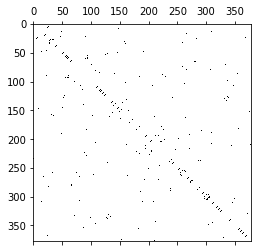

In [4]:
plt.figure()
plt.spy(A)

# Get Coordinates of nodes:

In [6]:
nodes = ctown.wn.nodes.todict()

In [7]:
coords_arr = np.array([nodes[key]['coordinates'] for key in nodes.keys()])
coords = pd.DataFrame(coords_arr, index=node_names_all)

# Clustering

## Prepocess Data:

In [8]:
data_path = '/home/ffiedler/tubCloud/Shared/WDN_SurrogateModels/_RESULTS/150sim_1hourSampling/'
file_list = os.listdir(data_path)
file_list = [file_i for file_i in file_list if '.pkl' in file_i]

press_junctions_list = []
qual_junctions_list = []
for file_i in file_list:
    with open(data_path+file_i, 'rb') as f:
        res_i=pickle.load(f)
    press_junctions_list.append(res_i.node['pressure'][node_names[2]])
    qual_junctions_list.append(res_i.node['quality'][node_names[2]])
 

press_junctions = pd.concat(press_junctions_list[:-2])
qual_junctions = pd.concat(qual_junctions_list[:-2])

press_junctions_val = press_junctions_list[-1]
qual_junctions_val = qual_junctions_list[-1]

In [9]:
if False:
    fig, ax = plt.subplots(2,1,figsize=(9,4), sharex=True)
    res_i.node['pressure'].plot(ax=ax[0], legend=False, linewidth=0.5, color='k', alpha=0.4)
    ax[0].set_ylabel('pressure ')


    res_i.node['demand'][node_names[2]].plot(ax=ax[1], legend=False, linewidth=0.5, color='k', alpha=0.2)
    ax[1].set_ylabel('sum of \n cluster demand')

    ax[1].set_xlabel('time [s]')
    plt.show()

Filter negative and unrealistic values:

In [10]:
if False:
    press_junctions = press_junctions[~(press_junctions<0).any(axis=1)]
    press_junctions = press_junctions[~(press_junctions>200).any(axis=1)]

Normalize Data:

In [11]:
scaling_press = press_junctions.abs().mean()
press_junctions /= scaling_press
scaling_press_df = pd.DataFrame(scaling_press).T
scaling_press_df.index = ['pressure_scaling']

Cluster Settings:

In [73]:
n_clusters = 30

## Pressure Clustering

In [13]:
clustering = FeatureAgglomeration(n_clusters=n_clusters, connectivity=A, linkage='ward').fit(press_junctions.to_numpy())
press_cluster_labels = pd.DataFrame(clustering.labels_.reshape(1,-1), columns=node_names[2], index=['pressure_cluster'])

In [14]:
press_cluster_labels

,J511,J411,J414,J415,J416,J417,J418,J419,J310,J311,...,J287,J288,J289,J300,J301,J302,J304,J306,J307,J317
pressure_cluster,19,2,15,4,4,15,13,13,1,1,...,13,13,13,13,25,25,12,12,25,3


<IPython.core.display.Javascript object>


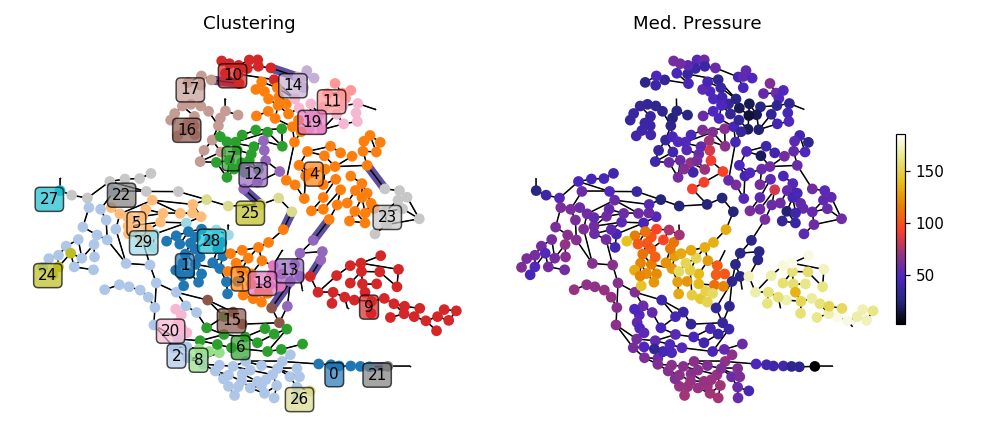

In [81]:
cmap = matplotlib.cm.get_cmap('tab20')

fig_1, ax_1 = plt.subplots(1,2, figsize=(9,4), sharex=True, sharey=True)
compare_to = 0
press = press_junctions_list[compare_to]
press_med = press.median()

# Highlight pumps
wntr.graphics.plot_network(ctown.wn, link_attribute=pump_df.loc[0],node_size=1, link_width=6, 
                           add_colorbar=False, title='Pumps', ax=ax_1[0])
# Highlight valves
wntr.graphics.plot_network(ctown.wn, link_attribute=valves_df.loc[0],node_size=1, link_width=6, 
                           add_colorbar=False, title='Valves', ax=ax_1[0])

lines = wntr.graphics.plot_network(ctown.wn, node_attribute=press_cluster_labels.loc['pressure_cluster'],
                                   node_size=50, node_labels=False, node_cmap='tab20',
                                   add_colorbar=False, title='Clustering', ax=ax_1[0]) 

wntr.graphics.plot_network(ctown.wn, node_attribute=press_med[node_names[2]],node_size=50, 
                           node_cmap='CMRmap', title='Med. Pressure', ax=ax_1[1])  


if True:
    for i in range(n_clusters):
        cluster_mean = coords.loc[node_names[2]][clustering.labels_==i].median()-100
        ax_1[0].text(*cluster_mean.tolist(), str(i), ha="center", va="center",
                     bbox=dict(boxstyle="round", ec='k', fc=cmap(i/n_clusters), alpha=0.7))
if False:
    for i in range(n_junctions):
        node_loc = coords.loc[node_names[2][i]]
        ax_1[0].text(*node_loc.tolist(), str(clustering.labels_[i]), ha="center", va="center")
    


fig_1.tight_layout()



### Evaluation

In [16]:
compare_to = 0

press_junction_i = press_junctions_list[compare_to]/ scaling_press
# Calculate cluster mean and standard deviation
jun_cl_press_group = press_junction_i.groupby(press_cluster_labels.loc['pressure_cluster'], axis=1)
jun_cl_press_mean = jun_cl_press_group.mean()
jun_cl_press_std = jun_cl_press_group.std()

<IPython.core.display.Javascript object>


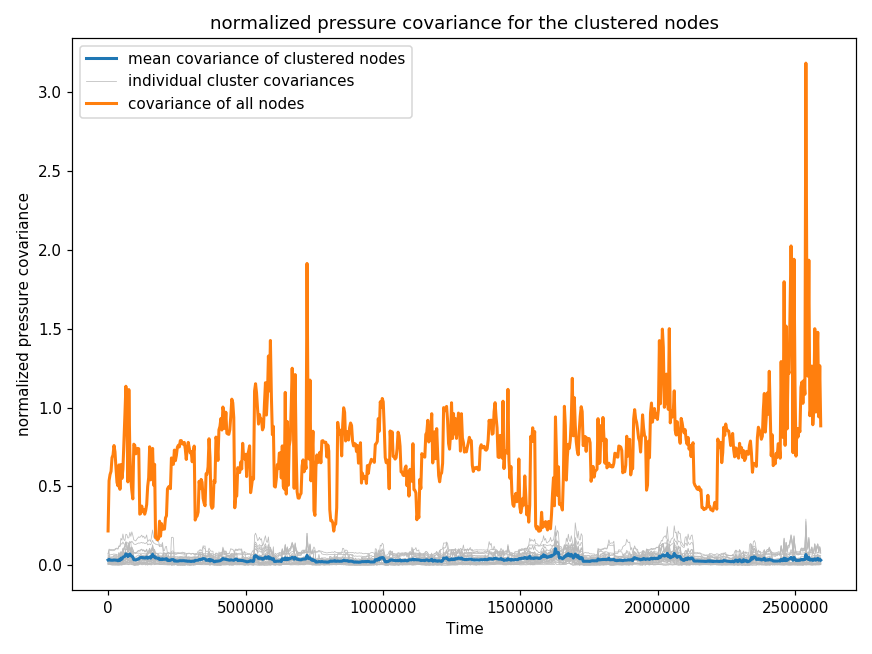

In [17]:
fig_2, ax_2 = plt.subplots(figsize=(8,6))

ax_2.plot(jun_cl_press_std, color='#bbbbbb', linewidth=0.5)
ax_2.plot(jun_cl_press_std.mean(axis=1), linewidth=2, alpha=1, label='mean covariance of clustered nodes')
ax_2.plot([0,0],[0,0], color='#bbbbbb', linewidth=0.5, label='individual cluster covariances')


press_std_ges = press_junction_i.std(axis=1)
ax_2.plot(press_std_ges, linewidth=2, alpha=1, label='covariance of all nodes')
ax_2.set_xlabel('Time')
ax_2.set_ylabel('normalized pressure covariance')
ax_2.set_title('normalized pressure covariance for the clustered nodes')

ax_2.legend()
fig_2.tight_layout()   

<IPython.core.display.Javascript object>


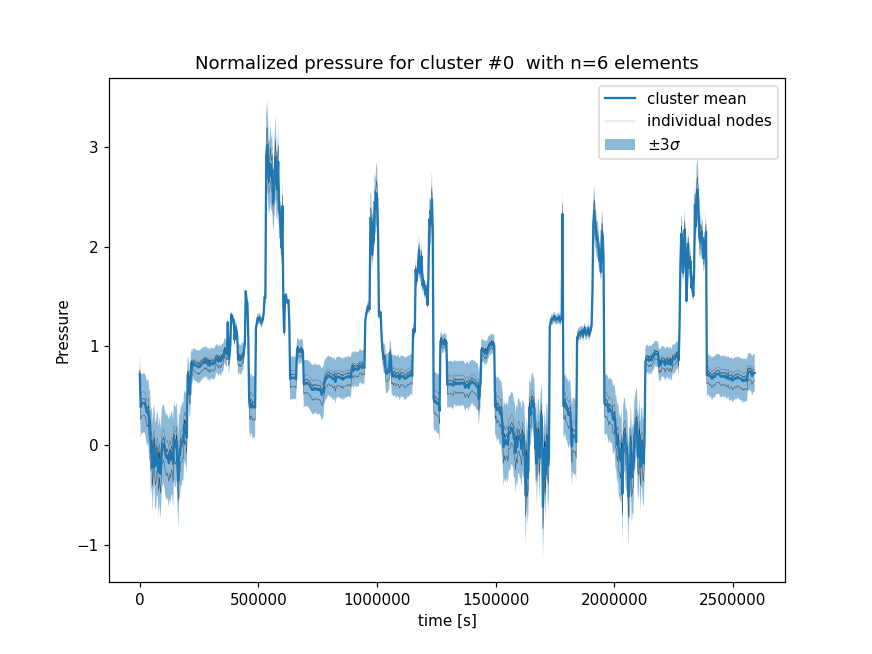

Text(0, 0.5, 'Pressure')

In [18]:
fig_2, ax_2 = plt.subplots(figsize=(8,6))

cluster_i=0

ax_2.fill_between(jun_cl_press_mean.index,
                  (jun_cl_press_mean[[cluster_i]]-3*jun_cl_press_std[[cluster_i]]).to_numpy().flatten(),
                  (jun_cl_press_mean[[cluster_i]]+3*jun_cl_press_std[[cluster_i]]).to_numpy().flatten(), 
                  alpha=0.5, label='$\pm 3\sigma$')
ax_2.plot(jun_cl_press_group.get_group(cluster_i),color='k', linewidth=0.2, alpha=0.5)
ax_2.plot(jun_cl_press_mean[[cluster_i]], label='cluster mean')
ax_2.plot([0,0],[0,0], color='k', linewidth=0.2, alpha=0.5, label='individual nodes')

ax_2.legend()
ax_2.set_title('Normalized pressure for cluster #{}  with n={} elements'.format(cluster_i, jun_cl_press_group.get_group(cluster_i).shape[1]))
ax_2.set_xlabel('time [s]')
ax_2.set_ylabel('Pressure')


## Cross-Validation:

In [63]:
# Scale with the same factors as above
press_junctions_val /= scaling_press
# Calculate cluster mean and standard deviation
jun_cl_press_group_val = press_junctions_val.groupby(press_cluster_labels.loc['pressure_cluster'], axis=1)
jun_cl_press_mean_val = jun_cl_press_group_val.mean()
jun_cl_press_std_val = jun_cl_press_group_val.std()

<IPython.core.display.Javascript object>


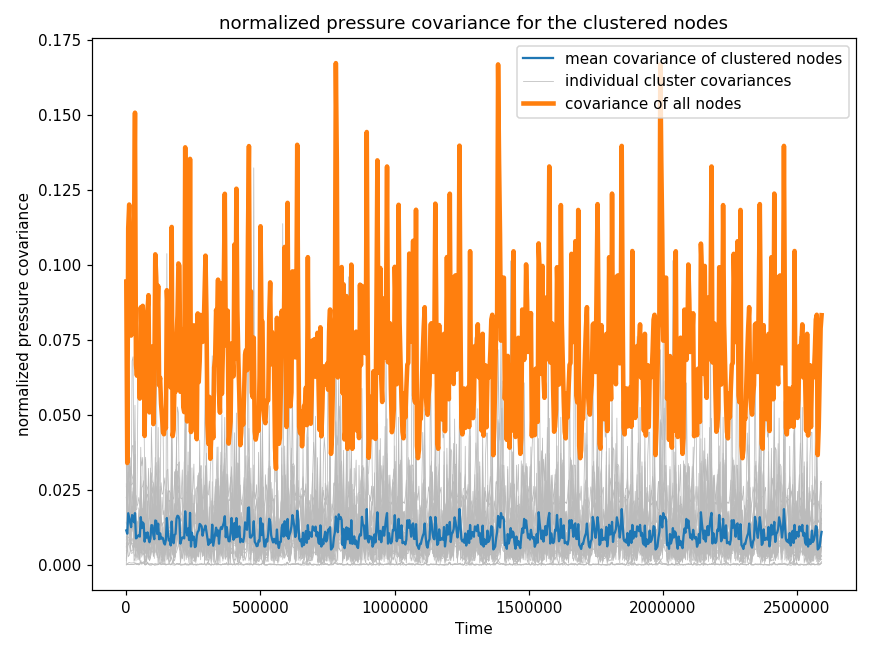

In [64]:
fig_2, ax_2 = plt.subplots(figsize=(8,6))

ax_2.plot(jun_cl_press_std_val, color='#bbbbbb', linewidth=0.5)
ax_2.plot(jun_cl_press_std_val.mean(axis=1), label='mean covariance of clustered nodes')
ax_2.plot([0,0],[0,0], color='#bbbbbb', linewidth=0.5, label='individual cluster covariances')


press_std_ges_val = press_junctions_val.std(axis=1)
ax_2.plot(press_std_ges_val, linewidth=3, label='covariance of all nodes')
ax_2.set_xlabel('Time')
ax_2.set_ylabel('normalized pressure covariance')
ax_2.set_title('normalized pressure covariance for the clustered nodes')

ax_2.legend()
fig_2.tight_layout()  

<IPython.core.display.Javascript object>


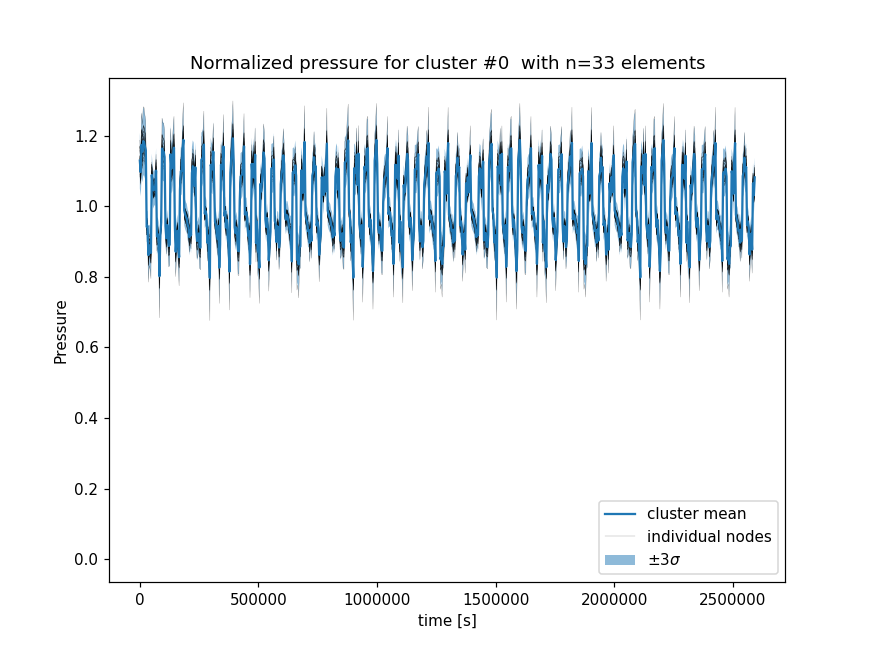

Text(0, 0.5, 'Pressure')

In [66]:
fig_2, ax_2 = plt.subplots(figsize=(8,6))

cluster_i=0


ax_2.fill_between(jun_cl_press_mean_val.index,
                  (jun_cl_press_mean_val[[cluster_i]]-3*jun_cl_press_std_val[[cluster_i]]).to_numpy().flatten(),
                  (jun_cl_press_mean_val[[cluster_i]]+3*jun_cl_press_std_val[[cluster_i]]).to_numpy().flatten(), 
                  alpha=0.5, label='$\pm 3\sigma$')
ax_2.plot(jun_cl_press_group_val.get_group(cluster_i),color='k', linewidth=0.2, alpha=0.5)
ax_2.plot(jun_cl_press_mean_val[[cluster_i]], label='cluster mean')
ax_2.plot([0,0],[0,0], color='k', linewidth=0.2, alpha=0.5, label='individual nodes')

ax_2.legend()
ax_2.set_title('Normalized pressure for cluster #{}  with n={} elements'.format(cluster_i, jun_cl_press_group.get_group(cluster_i).shape[1]))
ax_2.set_xlabel('time [s]')
ax_2.set_ylabel('Pressure')

## Quality Clustering

In [67]:
if False:
    fig, ax = plt.subplots()
    ax.plot(qual_junctions.index, qual_junctions, color='k', linewidth=0.2, alpha=.4)
    ax.set_xlabel('time [s]')
    ax.set_ylabel('quality')

Normalize Data:

In [68]:
scaling_qual = qual_junctions.mean().mean()
qual_junctions /=  scaling_qual

In [69]:
scaling_qual

119785.81

Cluster Settings:

In [70]:
n_clusters = 30

In [71]:
clustering = FeatureAgglomeration(n_clusters=n_clusters, connectivity=A, linkage='ward').fit(qual_junctions.to_numpy())

qual_cluster_labels = pd.DataFrame(clustering.labels_.reshape(1,-1), 
                                   columns=node_names[2], 
                                   index=['quality'])
cluster_labels = press_cluster_labels.append(qual_cluster_labels)

<IPython.core.display.Javascript object>


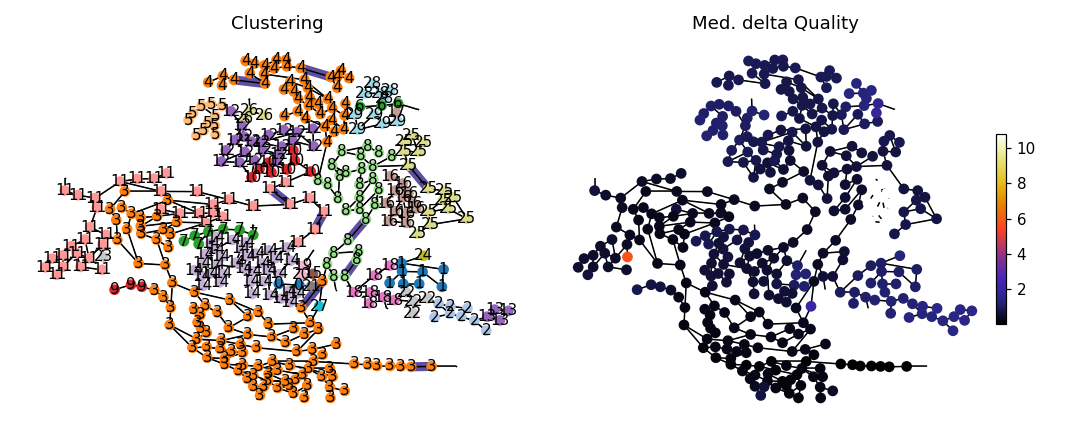

In [72]:
fig_2, ax_2 = plt.subplots(1,2, figsize=(10,4), sharex=True, sharey=True)
qual_junctions_mean = qual_junctions.mean()

wntr.graphics.plot_network(ctown.wn, link_attribute=pump_df.loc[0],node_size=1, link_width=6, add_colorbar=False, title='Pumps', ax=ax_2[0])
wntr.graphics.plot_network(ctown.wn, link_attribute=valves_df.loc[0],node_size=1, link_width=6, add_colorbar=False, title='Valves', ax=ax_2[0])

lines = wntr.graphics.plot_network(ctown.wn, node_attribute=qual_cluster_labels.loc['quality'],
                                   node_size=50, node_labels=False, node_cmap='tab20',
                                   add_colorbar=False, title='Clustering', ax=ax_2[0])  # clustering
wntr.graphics.plot_network(ctown.wn, node_attribute=qual_junctions_mean,node_size=50, 
                           node_cmap='CMRmap', title='Med. delta Quality', ax=ax_2[1])  # junctions


if False:
    for i in range(n_clusters):
        cluster_mean = coords.loc[node_names[2]][clustering.labels_==i].mean()
        ax_2[0].text(*cluster_mean.tolist(), str(i), ha="center", va="center",
                     bbox=dict(boxstyle="round", ec=(1., 0.5, 0.5), fc=(1., 0.8, 0.8), alpha=0.8))
if True:
    for i in range(n_junctions):
        node_loc = coords.loc[node_names[2][i]]
        ax_2[0].text(*node_loc.tolist(), str(clustering.labels_[i]), ha="center", va="center")
    


fig_2.tight_layout()



### Evaluation

In [73]:
# Calculate cluster mean and standard deviation
compare_to = 0

qual_junction_i = qual_junctions_list[compare_to]/ scaling_qual

jun_cl_qual_group = qual_junction_i.groupby(cluster_labels.loc['quality'], axis=1)
jun_cl_qual_mean = jun_cl_qual_group.mean()
jun_cl_qual_max = jun_cl_qual_group.max()
jun_cl_qual_max_95 =jun_cl_qual_group.aggregate(lambda arr: np.percentile(arr,axis=1, q=95))
jun_cl_qual_std = jun_cl_qual_group.std()

<IPython.core.display.Javascript object>


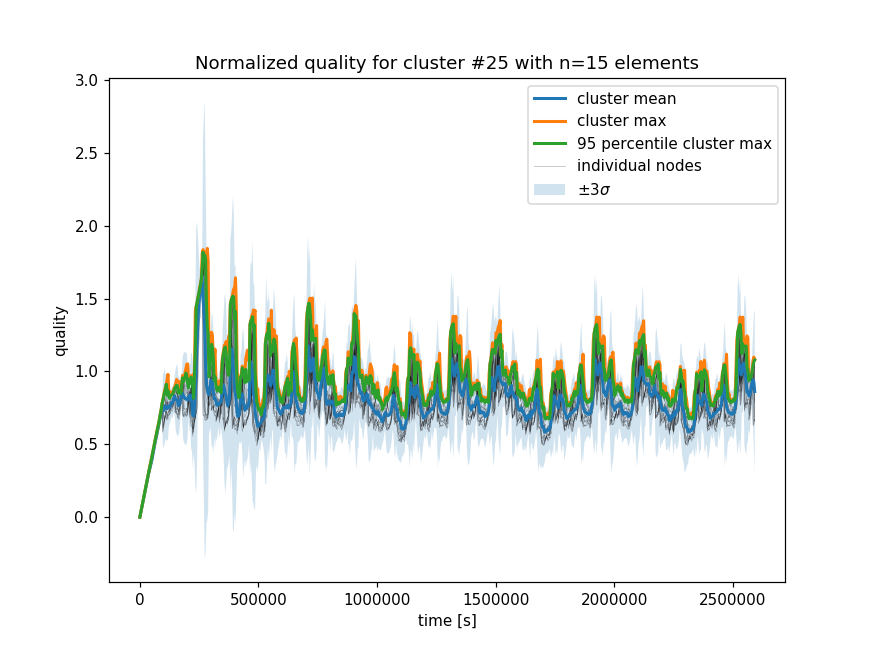

Text(0, 0.5, 'quality')

In [77]:
fig_2, ax_2 = plt.subplots(figsize=(8,6))

cluster_i=25

ax_2.fill_between(jun_cl_qual_mean.index,
                  (jun_cl_qual_mean[[cluster_i]]-3*jun_cl_qual_std[[cluster_i]]).to_numpy().flatten(),
                  (jun_cl_qual_mean[[cluster_i]]+3*jun_cl_qual_std[[cluster_i]]).to_numpy().flatten(), 
                  alpha=0.2, label='$\pm 3\sigma$')
ax_2.plot(jun_cl_qual_group.get_group(cluster_i), color='k', linewidth=0.2, alpha=0.5)
ax_2.plot(jun_cl_qual_mean[[cluster_i]], label='cluster mean', linewidth=2)
ax_2.plot(jun_cl_qual_max[[cluster_i]], label='cluster max', linewidth=2)
ax_2.plot(jun_cl_qual_max_95[[cluster_i]], label='95 percentile cluster max', linewidth=2)
ax_2.plot([0,0],[0,0], color='#bbbbbb', linewidth=0.5, label='individual nodes')

ax_2.legend()
ax_2.set_title('Normalized quality for cluster #{} with n={} elements'.format(cluster_i, jun_cl_qual_group.get_group(cluster_i).shape[1]))
ax_2.set_xlabel('time [s]')
ax_2.set_ylabel('quality')

<IPython.core.display.Javascript object>


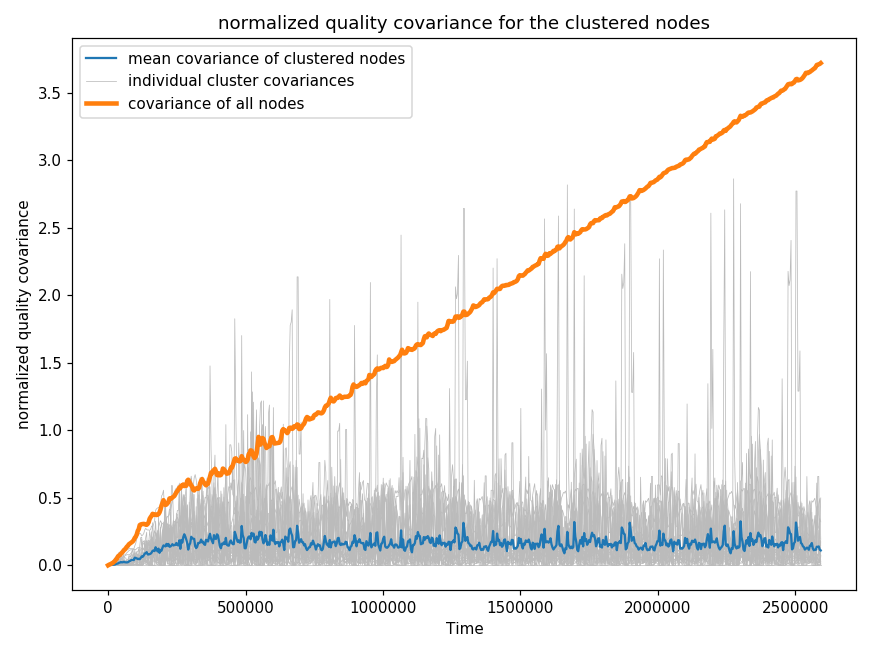

In [78]:
fig_2, ax_2 = plt.subplots(figsize=(8,6))

ax_2.plot(jun_cl_qual_std, color='#bbbbbb', linewidth=0.5)
ax_2.plot(jun_cl_qual_std.mean(axis=1), label='mean covariance of clustered nodes')
ax_2.plot([0,0],[0,0], color='#bbbbbb', linewidth=0.5, label='individual cluster covariances')


qual_std_ges = qual_junction_i.std(axis=1)
ax_2.plot(qual_std_ges, linewidth=3, label='covariance of all nodes')
ax_2.set_xlabel('Time')
ax_2.set_ylabel('normalized quality covariance')
ax_2.set_title('normalized quality covariance for the clustered nodes')

ax_2.legend()
fig_2.tight_layout()  

Export Cluster label

In [79]:
cluster_labels.to_json('cluster_labels_dt1h_default_control.json')
scaling_press_df.to_json('pressure_factor_dt1h_default_control.json')

In [100]:
# cluster_setup = {
#     'cluster_labels': cluster_labels,
#     'pressure_scaling': scaling_press_df
# }

# with open('150sim_cluster_param.pkl','wb') as f:
#     pickle.dump(cluster_setup,f)